# Gradient Boosting Reinforcement Learning (GBRL)
GBRL is a Python-based GBT library designed and optimized for reinforcement learning (RL).
GBRL is designed to be integrated in popular RL python libraries as part of the standard RL training loop.  

## GBRL Design
The standard GBT supervised learning training procedure for K boosting iterations on a given set on inputs x and targets y is as follows:  
***For K boosting iterations***   
1. Generate predictions using current GBT ensemble.
2. Calculate loss L(y, predictions).
3. Calculate gradients of the loss function w.r.t predictions  
4. Fit a binary decision tree on the gradients and add it to the ensemble.
5. Repeat from step 1.

The training procedure is typically done E2E within a GBT framework and is optimized for pre-defined loss functions. GBRL modifies this procedure to seemingly integrate within RL loops by:
- Outsourcing gradient calculation to autograd frameworks.
- Incremental learning by performing a single boosting iteration on a given data batch containing pairs of states/observations and gradients.  


## Get Started with GBRL
This is a quick tutorial demonstrating usage examples



### Basic Usage: Training, Saving, Loading

In [1]:
import numpy as np
import torch as th
import gymnasium as gym 

from sklearn import datasets
from torch.nn.functional import mse_loss 
from torch.distributions import Categorical

from gbrl import GradientBoostingTrees, cuda_available, ParametricActor

In [2]:
# incremental learning dataset
X_numpy, y_numpy = datasets.load_diabetes(return_X_y=True, as_frame=False, scaled=False)
# GBRL works with 2D arrays
out_dim = 1 if len(y_numpy.shape) == 1  else  y_numpy.shape[1]
if out_dim == 1:
    y_numpy = y_numpy[:, np.newaxis]

X, y = th.tensor(X_numpy, dtype=th.float32), th.tensor(y_numpy, dtype=th.float32)
# CUDA is not deterministic
device = 'cuda' if cuda_available else 'cpu'

# initializing model parameters
tree_struct = {'max_depth': 4, 
               'n_bins': 256,
               'min_data_in_leaf': 0,
               'par_th': 2,
               'grow_policy': 'oblivious'
        }

optimizer = { 'algo': 'SGD',
              'lr': 1.0,
            }
gbrl_params = {
               "split_score_func": "Cosine",
               "generator_type": "Quantile"
                }

In [3]:
# setting up model
gbt_model = GradientBoostingTrees(
                    output_dim=out_dim,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    device=device)
gbt_model.set_bias_from_targets(y)

Setting GBRL device to cuda
Setting policy optimizer indices: 0->1


In [4]:
# training for 10 epochs
n_epochs = 10
for _ in range(n_epochs):
    # forward pass - setting requires_grad=True is mandatory for training
    # y_pred is a torch tensor
    y_pred = gbt_model(X, requires_grad=True)
    # calculate loss - we must scale pytorch's mse loss function by 0.5 to get the correct MSE gradient
    loss = 0.5*mse_loss(y_pred, y) 
    loss.backward()
    # perform a boosting step
    gbt_model.step(X)
    print(f"Boosting iteration: {gbt_model.get_iteration()} RMSE loss: {loss.sqrt()}")
    

Boosting iteration: 1 RMSE loss: 54.45128631591797
Boosting iteration: 2 RMSE loss: 45.69207763671875
Boosting iteration: 3 RMSE loss: 40.96660232543945
Boosting iteration: 4 RMSE loss: 38.452999114990234


Boosting iteration: 5 RMSE loss: 37.19563293457031
Boosting iteration: 6 RMSE loss: 36.10505294799805
Boosting iteration: 7 RMSE loss: 35.0928955078125
Boosting iteration: 8 RMSE loss: 34.05934524536133
Boosting iteration: 9 RMSE loss: 33.4926872253418
Boosting iteration: 10 RMSE loss: 32.695125579833984


GBT work with per-sample gradients but pytorch typically calculates the expected loss. GBRL internally multiplies the gradients with the number of samples when calling the step function. Therefore, when working with pytorch losses and multi-output targets one should take this into consideration.  
For example:
1. When using a summation reduction

In [5]:
gbt_model = GradientBoostingTrees(
                    output_dim=out_dim,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    device=device)
gbt_model.set_bias_from_targets(y)
# continuing training 10  epochs using a sum reduction
n_epochs = 10
for _ in range(n_epochs):
    y_pred = gbt_model(X, requires_grad=True)
    # we divide the loss by the number of samples to compensate for GBRL's built-in multiplication by the same value   
    loss = 0.5*mse_loss(y_pred, y, reduction='sum') / len(y_pred) 
    loss.backward()
    # perform a boosting step
    gbt_model.step(X)
    print(f"Boosting iteration: {gbt_model.get_iteration()} RMSE loss: {loss.sqrt()}")
    

Setting GBRL device to cuda
Setting policy optimizer indices: 0->1
Boosting iteration: 1 RMSE loss: 54.45128631591797
Boosting iteration: 2 RMSE loss: 45.69207763671875
Boosting iteration: 3 RMSE loss: 40.96660232543945
Boosting iteration: 4 RMSE loss: 38.452999114990234
Boosting iteration: 5 RMSE loss: 37.19563293457031
Boosting iteration: 6 RMSE loss: 36.10505294799805
Boosting iteration: 7 RMSE loss: 35.0928955078125
Boosting iteration: 8 RMSE loss: 34.05934143066406
Boosting iteration: 9 RMSE loss: 33.4926872253418
Boosting iteration: 10 RMSE loss: 32.695125579833984


2. When working with multi-dimensional outputs

In [6]:
y_multi = th.concat([y, y], dim=1)
out_dim = y_multi.shape[1]
gbt_model = GradientBoostingTrees(
                    output_dim=out_dim,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    device=device)
gbt_model.set_bias_from_targets(y_multi)
# continuing training 10  epochs using a sum reduction
n_epochs = 10
for _ in range(n_epochs):
    y_pred = gbt_model(X, requires_grad=True)
    # we multiply the loss by the output dimension to compensate for pytorch's mean reduction for MSE loss that averages across all dimensions.
    # this step is necessary to get the correct loss gradient - however the loss value itself is correct
    loss = 0.5*mse_loss(y_pred, y_multi) * out_dim
    loss.backward()
    # perform a boosting step
    gbt_model.step(X)
    print(f"Boosting iteration: {gbt_model.get_iteration()} RMSE loss: {(loss / out_dim).sqrt()}")
    

Setting GBRL device to cuda
Setting policy optimizer indices: 0->2
Boosting iteration: 1 RMSE loss: 54.45128631591797
Boosting iteration: 2 RMSE loss: 45.69207763671875
Boosting iteration: 3 RMSE loss: 40.96660232543945


Boosting iteration: 4 RMSE loss: 38.4530029296875
Boosting iteration: 5 RMSE loss: 37.19563293457031
Boosting iteration: 6 RMSE loss: 36.10505676269531
Boosting iteration: 7 RMSE loss: 35.092899322509766
Boosting iteration: 8 RMSE loss: 34.05934524536133
Boosting iteration: 9 RMSE loss: 33.4926872253418
Boosting iteration: 10 RMSE loss: 32.695125579833984


### Saving, loading, and copying a GBRL Model

In [7]:
# Call the save_model method of a GBRL class
# GBRL will automatically save the file with the .gbrl_model ending
# The file will be saved in the current working directory
# Provide the absolute path to save the file in a different directory.
gbt_model.save_model('gbt_model_tutorial')
# Loading a saved model is similar and is done by calling the specific class instance.
loaded_gbt_model = GradientBoostingTrees.load_model('gbt_model_tutorial')
# Copying a model is even more straighforward
copied_model = gbt_model.copy()

Current GBRL Library Version 1.0.1
Reading GBRL Library Version 1.0.1
######## Loaded GBRL model ########
output_dim: 2 policy_dim: 2 max_depth: 4 min_data_in_leaf: 0
generator_type: Quantile n_bins: 256 cv_beta: 0.9 split_score_func: Cosine
grow_policy: Oblivous verbose: 0 device: cpu use_cv: 0 batch_size: 5000
Loaded: 160 leaves from 10 trees
Model has: 1 optimizers 
Setting GBRL device to cpu
Setting policy optimizer indices: 0->2


### Using Manually Calculated Gradients
Alternatively GBRL can use manually calculated gradients.  Calling the `predict` method instead of the `__call__` method, returns a numpy array instead of a PyTorch tensor. Autograd libraries or manual calculations can be used to calculate gradients.  
Fitting manually calculated gradients is done using the `_model.step` method that receives numpy arrays. 


In [8]:
# initializing model parameters
tree_struct = {'max_depth': 4, 
               'n_bins': 256,
               'min_data_in_leaf': 0,
               'par_th': 2,
               'grow_policy': 'oblivious'
        }

optimizer = { 'algo': 'SGD',
              'lr': 1.0,
            }
gbrl_params = {
               "split_score_func": "Cosine",
               "generator_type": "Quantile"
                }
# setting up model
gbt_model = GradientBoostingTrees(
                    output_dim=1,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    device=device)
# works with numpy arrays as well as PyTorch tensors
gbt_model.set_bias_from_targets(y_numpy)

# training for 10 epochs
n_epochs = 10
for _ in range(n_epochs):
    # y_pred is a numpy array
    y_pred = gbt_model.predict(X_numpy)
    loss = np.sqrt(0.5*((y_pred - y_numpy)**2).mean()) 
    grads = y_pred - y_numpy
    # perform a boosting step
    gbt_model._model.step(X_numpy, grads)
    print(f"Boosting iteration: {gbt_model.get_iteration()} RMSE loss: {loss}")

Setting GBRL device to cuda
Setting policy optimizer indices: 0->1
Boosting iteration: 1 RMSE loss: 54.451285094616374
Boosting iteration: 2 RMSE loss: 45.69207739644566
Boosting iteration: 3 RMSE loss: 40.96660135235073
Boosting iteration: 4 RMSE loss: 38.45300057763524
Boosting iteration: 5 RMSE loss: 37.195630605541474
Boosting iteration: 6 RMSE loss: 36.10505468425762
Boosting iteration: 7 RMSE loss: 35.09289710590169
Boosting iteration: 8 RMSE loss: 34.05934419461358
Boosting iteration: 9 RMSE loss: 33.49268814968545
Boosting iteration: 10 RMSE loss: 32.69512556998024


## Multiple iterations at once (standard supervised learning)
GBRL supports training multiple boosting iterations with targets similar to other GBT libraries. This is done using the `fit` method.  
***Note: only the RMSE loss function is supported for the `fit` method***

In [9]:
gbt_model = GradientBoostingTrees(
                    output_dim=1,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=1,
                    device=device)
final_loss = gbt_model.fit(X_numpy, y_numpy, iterations=10)


Setting GBRL device to cuda
Setting policy optimizer indices: 0->1
Boosting iteration: 1 - MultiRMSE Loss: 45.8316
Boosting iteration: 2 - MultiRMSE Loss: 41.0831
Boosting iteration: 3 - MultiRMSE Loss: 38.6881
Boosting iteration: 4 - MultiRMSE Loss: 37.4553


Boosting iteration: 5 - MultiRMSE Loss: 36.278
Boosting iteration: 6 - MultiRMSE Loss: 35.073
Boosting iteration: 7 - MultiRMSE Loss: 34.0284
Boosting iteration: 8 - MultiRMSE Loss: 33.2854
Boosting iteration: 9 - MultiRMSE Loss: 32.4714
Boosting iteration: 10 - MultiRMSE Loss: 31.6558


## RL using GBRL
Now that we have seen how GBRL is trained using incremental learning and PyTorch we can use it within an RL training loop

Let's start by training a simple Reinforce algorithm

In [10]:
def calculate_returns(rewards, gamma):
    returns = []
    running_g = 0.0
    for reward in rewards[::-1]:
        running_g = reward + gamma * running_g
        returns.insert(0, running_g)
    return returns

In [11]:
env = gym.make("CartPole-v1")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
num_episodes = 1000
gamma = 0.99
optimizer = { 'algo': 'SGD',
              'lr': 0.05,
            }

bias = np.zeros(env.action_space.n, dtype=np.single)
agent = ParametricActor(
                    output_dim=env.action_space.n,
                    tree_struct=tree_struct,
                    policy_optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    bias=bias, 
                    device='cpu')

update_every = 20

rollout_buffer = {'actions': [], 'obs': [], 'returns': []}
for episode in range(num_episodes):
    # gymnasium v26 requires users to set seed while resetting the environment
    obs, info = wrapped_env.reset(seed=0)
    rollout_buffer['rewards'] = []

    done = False
    while not done:
        action_logits = agent(obs)
        action = Categorical(logits=action_logits).sample()
        action_numpy = action.cpu().numpy()
        
        obs, reward, terminated, truncated, info = wrapped_env.step(action_numpy.squeeze())
        rollout_buffer['rewards'].append(reward)
        rollout_buffer['obs'].append(obs)
        rollout_buffer['actions'].append(action)

        done = terminated or truncated
    
    rollout_buffer['returns'].extend(calculate_returns(rollout_buffer['rewards'], gamma))


    if episode % update_every == 0 and episode > 0:
        returns = th.tensor(rollout_buffer['returns'])
        actions = th.cat(rollout_buffer['actions'])
        # input to model can be either a torch tensor or a numpy ndarray
        observations = np.stack(rollout_buffer['obs'])
        # model update
        action_logits = agent(observations, requires_grad=True)
        dist = Categorical(logits=action_logits)
        log_probs = dist.log_prob(actions)
        # calculate reinforce loss with subtracted baseline
        loss = -(log_probs*(returns - returns.mean())).mean()
        loss.backward()
        grads = agent.step(observations)
        rollout_buffer = {'actions': [], 'obs': [], 'returns': []}

    if episode % 100 == 0:
        print(f"Episode {episode} - boosting iteration: {agent.get_iteration()} episodic return: {np.mean(wrapped_env.return_queue)}")
        

Setting GBRL device to cpu
Setting policy optimizer indices: 0->2
Episode 0 - boosting iteration: 0 episodic return: 14.0
Episode 100 - boosting iteration: 5 episodic return: 26.3799991607666
Episode 200 - boosting iteration: 10 episodic return: 31.639999389648438
Episode 300 - boosting iteration: 15 episodic return: 33.560001373291016
Episode 400 - boosting iteration: 20 episodic return: 47.2599983215332
Episode 500 - boosting iteration: 25 episodic return: 64.33999633789062
Episode 600 - boosting iteration: 30 episodic return: 66.66000366210938
Episode 700 - boosting iteration: 35 episodic return: 91.44000244140625
Episode 800 - boosting iteration: 40 episodic return: 84.27999877929688
Episode 900 - boosting iteration: 45 episodic return: 65.26000213623047


# Explainability
GBRL implements SHAP value calculation. SHAP values can be calculated over the entire ensemble as well as for individual trees.
GBRL returns SHAP values with shap: [n_samples, n_features, n_actions]

In [12]:
# per tree shap values
tree_shap = agent.tree_shap(0, obs)
# for the entire ensemble
shap_values = agent.shap(obs)

SHAP values are calculated internally and can be plotted using the [SHAP library](https://github.com/shap/shap).


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


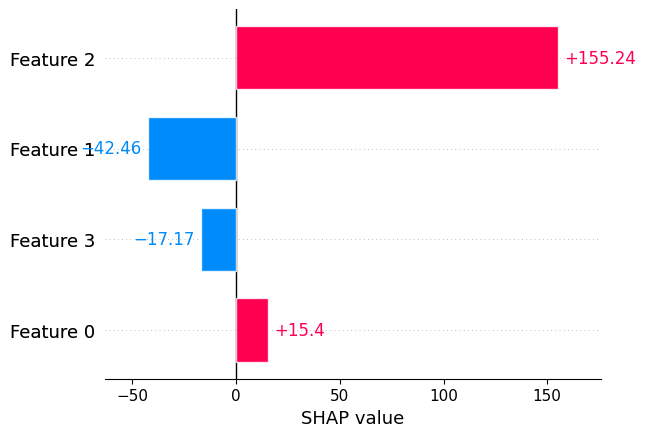

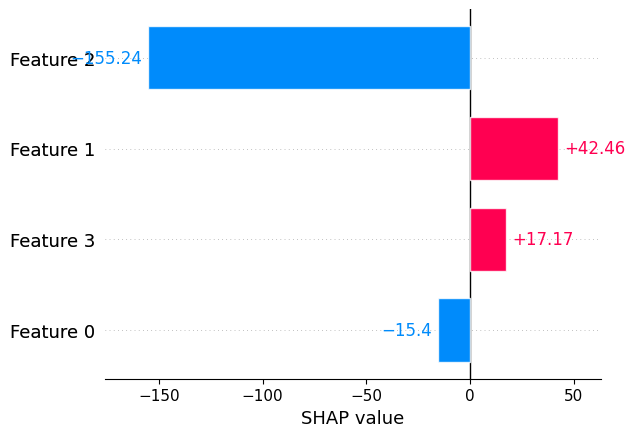

In [14]:
import shap
import matplotlib.pyplot as plt
plt.close('all')
explainable_values_action_1 = shap.Explanation(shap_values.squeeze()[: , 0])
explainable_values_action_2 = shap.Explanation(shap_values.squeeze()[: , 1])

fig, ax = plt.subplots()
shap.plots.bar(explainable_values_action_1, ax=ax)
ax.set_title("SHAP values Action 1")
fig, ax = plt.subplots()
shap.plots.bar(explainable_values_action_2, ax=ax)
ax.set_title("SHAP values Action 2")

plt.show()